# iris tomography codes and other stuff

In [1]:
import sqlite3 as sql
import sys
sys.path.append('..')
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from netCDF4 import num2date
units = 'days since 1858-11-17 00:00:00.000'

# import data from database

In [18]:
orbit = 20900
num_of_orbits = 0
ch = 3


db = sql.connect('/home/anqil/Documents/Python/iris/OSIRIS_three_orbits_test.db')
cur = db.cursor()

return_column = ('data, mjd, look_ecef, sc_position_ecef, latitude, longitude, altitude')              
select_str = 'SELECT {} FROM IRI JOIN channel{} ON IRI.stw = channel{}.stw WHERE orbit>={} AND orbit<={}'
result = cur.execute(select_str.format(return_column, ch, ch, orbit, orbit+num_of_orbits))
all_image = result.fetchall()
db.close()

if len(all_image) == 0:
    print('No data for this orbit(s)')
    

print('num of images: {}'.format(len(all_image)))

l1_blob = np.array(all_image)[:,0]
mjd = np.array(all_image)[:,1].astype(float)
date = num2date(mjd, units)
sc_look_blob = np.array(all_image)[:,2]
sc_pos_blob = np.array(all_image)[:,3]
tan_lat_blob = np.array(all_image)[:,4]
tan_lon_blob = np.array(all_image)[:,5]
tan_alt_blob = np.array(all_image)[:,6]

#====unfolding blobs
l1 = np.empty((len(all_image),128))
sc_look = np.empty((len(all_image), 128, 3))
sc_pos = np.empty((len(all_image), 3))
tan_lat = np.empty((len(all_image),128))
tan_lon = np.empty((len(all_image),128))
tan_alt = np.empty((len(all_image),128))
for i in range(len(all_image)):
    l1[i,:] = np.frombuffer(l1_blob[i])
    sc_look[i,:,:] = np.frombuffer(sc_look_blob[i]).reshape(128,3)
    sc_pos[i,:] = np.frombuffer(sc_pos_blob[i])
    tan_lat[i,:] = np.frombuffer(tan_lat_blob[i])
    tan_lon[i,:] = np.frombuffer(tan_lon_blob[i])
    tan_alt[i,:] = np.frombuffer(tan_alt_blob[i])
#====construct xarray data array
pixel = np.arange(128)
l1 = xr.DataArray(l1, coords=(date, pixel), 
                  dims=('date', 'pixel'), 
                  attrs={'units':'Rayleigh??'})
sc_look = xr.DataArray(sc_look, coords=(date, pixel, ['x', 'y', 'z']), 
                       dims=('date', 'pixel', 'xyz'))
sc_pos = xr.DataArray(sc_pos, coords=(date, ['x', 'y', 'z']), dims=('date', 'xyz'))
tan_lat = xr.DataArray(tan_lat, coords=(date, pixel),
                       dims=('date', 'pixel'), attrs={'units':'degree'})
tan_lon = xr.DataArray(tan_lon, coords=(date, pixel),
                       dims=('date', 'pixel'), attrs={'units':'degree'})
tan_alt = xr.DataArray(tan_alt, coords=(date, pixel),
                       dims=('date', 'pixel'), attrs={'units':'meter'})

#====drop all dates which have nan in l1
l1 = l1.dropna('date')
sc_look = sc_look.sel(date=l1.dropna('date').date)
sc_pos = sc_pos.sel(date=l1.dropna('date').date)
tan_lat = tan_lat.sel(date=l1.dropna('date').date)
tan_lon = tan_lon.sel(date=l1.dropna('date').date)
tan_alt = tan_alt.sel(date=l1.dropna('date').date)
date = l1.dropna('date').date.data
print('num of images after removing nan: {}'.format(len(date)))

num of images: 2890
num of images after removing nan: 2381


# 1D interpolation and plotting limb radiance

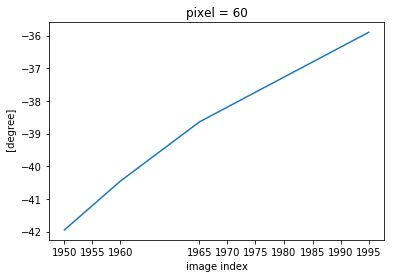

<Figure size 432x288 with 0 Axes>

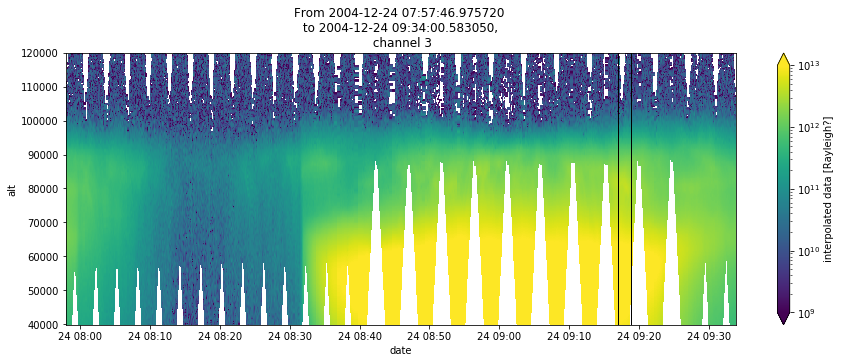

<Figure size 432x288 with 0 Axes>

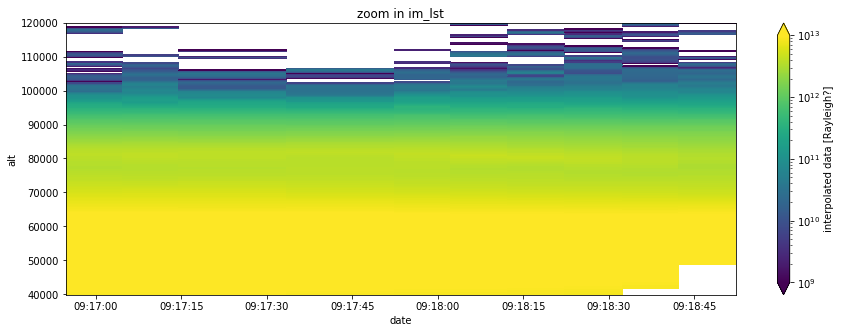

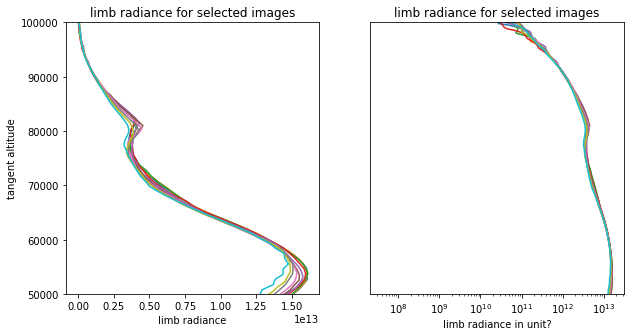

In [19]:
# choose some images to focus
im_lst = np.arange(1950,2000, 5)

tan_lat.isel(date=im_lst, pixel=60).plot()
ax = plt.gca()
ax.set_xticks(date[im_lst])
ax.set_xticklabels(im_lst)
ax.set(xlabel='image index')
plt.show()

alts_interp = np.arange(40e3, 120e3, .25e3)
data_interp = []

for (data, alt) in zip(l1, tan_alt):
    f = interp1d(alt, data, bounds_error=False)
    data_interp.append(f(alts_interp))
data_interp = xr.DataArray(data_interp, coords=(date, alts_interp), 
                           dims=('date', 'alt'))
data_interp.attrs['units'] = 'Rayleigh?'
data_interp.attrs['long_name'] = 'interpolated data'

#FIG_SIZE = (15,6)
plt.figure()
data_interp.plot(x='date', y='alt', 
                 norm=LogNorm(), 
                 vmin=1e9, vmax=1e13, 
                 size=5, aspect=3)
ax = plt.gca()
ax.set(title='From {} \n to {}, \n channel {}'.format(num2date(mjd[0],units),
       num2date(mjd[-1], units), ch))
plt.axvline(x=date[im_lst[0]], color='k', linewidth=1)
plt.axvline(x=date[im_lst[-1]], color='k', linewidth=1)
plt.show()

plt.figure()
data_interp.isel(date=im_lst).plot(x='date', y='alt', 
                 norm=LogNorm(), 
                 vmin=1e9, vmax=1e13, 
                 size=5, aspect=3)
ax = plt.gca()
ax.set(title='zoom in im_lst')
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(data_interp.isel(date=im_lst).T, alts_interp)
ax = plt.gca()
ax.set(ylabel='tangent altitude', 
       xlabel='limb radiance',
       title='limb radiance for selected images',
       ylim=[50e3,100e3])

plt.subplot(122)
plt.plot(data_interp.isel(date=im_lst).T, alts_interp)
ax = plt.gca()
ax.set(xlabel='limb radiance in unit?',
       title='limb radiance for selected images',
       ylim=[50e3,100e3])
ax.set_xscale('log')
plt.yticks([])
plt.show()

# 1D inversion for O2(1 delta) volumn emission rate


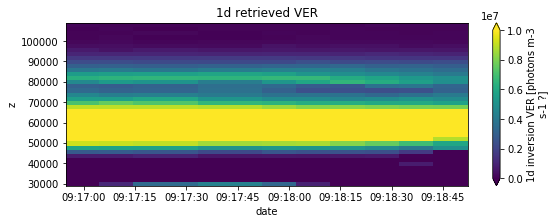

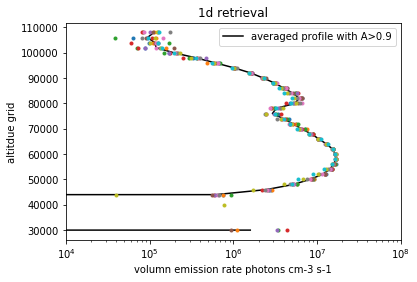

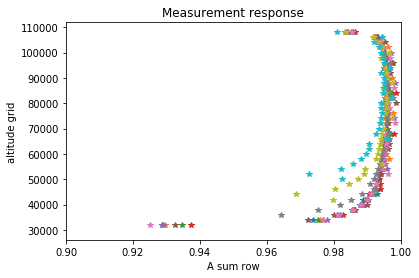

In [4]:
from oem_functions import linear_oem
from geometry_functions import pathl1d_iris

z = np.arange(30e3, 110e3, 2e3) # m
z_top = z[-1] + 2e3
result_1d = np.zeros((len(im_lst), len(z)))
xa = np.ones(len(z)) # temp
Sa = np.diag(np.ones(len(z))) *1e-9 #temp
Se = np.diag(np.ones(len(pixel))) * 30# 1e10 #30 #temporary
Ave = []
for i in range(len(im_lst)):
    h = tan_alt.isel(date=im_lst[i]).data
    K = pathl1d_iris(h, z, z_top)    
    y = l1.isel(date=im_lst[i]).data    
#    Se = np.diag(error.data[i,:]**2)
    x, A, Ss, Sm = linear_oem(K, Se, Sa, y, xa)
    result_1d[i,:] = x
    Ave.append(A.sum(axis=1)) #sum over rows 

result_1d = xr.DataArray(result_1d, 
                         coords=(date[im_lst], z), 
                         dims=('date', 'z'))
result_1d.attrs['units'] = 'photons m-3 s-1 ?'
result_1d.attrs['long_name'] = '1d inversion VER'
Ave = np.array(Ave)
threshold = 0.9
result_1d_mean = result_1d.where(Ave>threshold).mean(dim='date')

# plot VER results
result_1d.plot(x='date', y='z',
#         norm=LogNorm(), 
         vmin=0, vmax=1e7, 
         size=3, aspect=3)
ax = plt.gca()
ax.set(title='1d retrieved VER')
plt.show()

plt.figure()
result_1d_mean.plot(y='z', color='k',ls='-',
                    label='averaged profile with A>{}'.format(threshold))
ax = plt.gca()
ax.plot(result_1d.T, z, '.')
ax.set_xscale('log')
ax.set(xlim=[1e4, 1e8],
       xlabel='volumn emission rate photons cm-3 s-1', 
       ylabel='altitdue grid',
       title='1d retrieval')
ax.legend()
plt.show()

# plot averaging kernel
plt.plot(Ave.T, z, '*')
plt.xlabel('A sum row')
plt.ylabel('altitude grid')
plt.title('Measurement response')
plt.xlim([threshold, 1])
plt.show()

result_1d_pre = result_1d
result_1d_mean_pre = result_1d_mean

## using above mean result as xa and invert once more 

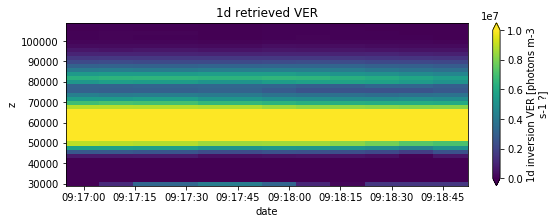

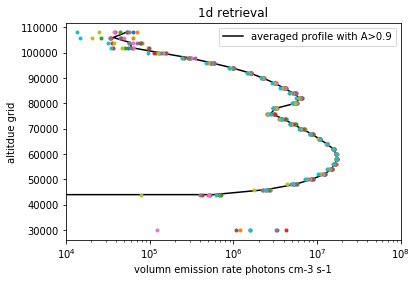

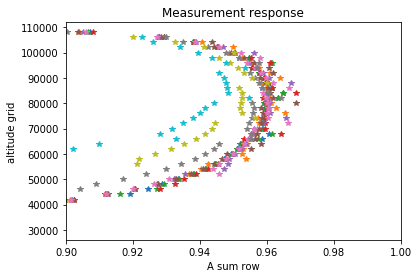

In [7]:
xa = result_1d_mean_pre.data
Sa = np.diag(np.ones(len(z))) *1e-10 #temp
Se = np.diag(np.ones(len(pixel))) * 30# 1e10 #temporary
result_1d = np.zeros((len(im_lst), len(z)))
Ave = []
for i in range(len(im_lst)):
    h = tan_alt.isel(date=im_lst[i]).data
    K = pathl1d_iris(h, z, z_top)    
    y = l1.isel(date=im_lst[i]).data    
#    Se = np.diag(error.data[i,:]**2)
    x, A, Ss, Sm = linear_oem(K, Se, Sa, y, xa)
    result_1d[i,:] = x
    Ave.append(A.sum(axis=1)) #sum over rows 

result_1d = xr.DataArray(result_1d, 
                         coords=(date[im_lst], z), 
                         dims=('date', 'z'))
result_1d.attrs['units'] = 'photons m-3 s-1 ?'
result_1d.attrs['long_name'] = '1d inversion VER'
Ave = np.array(Ave)
#threshold = 0.9
result_1d_mean = result_1d.where(Ave>threshold).mean(dim='date')

# plot VER results
result_1d.plot(x='date', y='z',
#         norm=LogNorm(), 
         vmin=0, vmax=1e7, 
         size=3, aspect=3)
ax = plt.gca()
ax.set(title='1d retrieved VER')
plt.show()

plt.figure()
result_1d_mean.plot(y='z', color='k',ls='-',
                    label='averaged profile with A>{}'.format(threshold))
ax = plt.gca()
ax.plot(result_1d.T, z, '.')
ax.set_xscale('log')
ax.set(xlim=[1e4, 1e8],
       xlabel='volumn emission rate photons cm-3 s-1', 
       ylabel='altitdue grid',
       title='1d retrieval')
ax.legend()
plt.show()

# plot averaging kernel
plt.plot(Ave.T, z, '*')
plt.xlabel('A sum row')
plt.ylabel('altitude grid')
plt.title('Measurement response')
plt.xlim([threshold, 1])
plt.show()



# Ozone

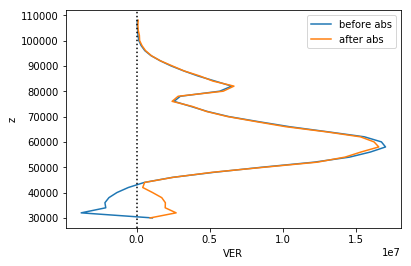

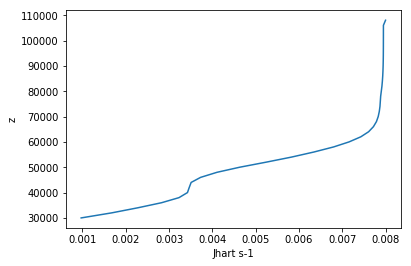

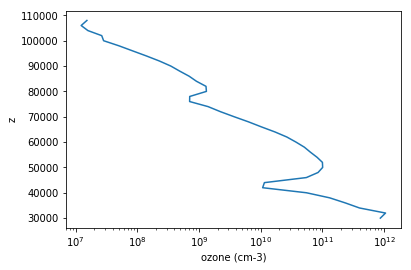

In [8]:
from chemi import ozone_sme, ozone_textbook, oxygen_atom, jfactors, gfactor
from scipy.io import loadmat
import sys
sys.path.append('..')
MSIS = loadmat('../msisdata.mat')
zMsis = MSIS['zMsis'].squeeze() # in km
TMsis = MSIS['TMsis'] # in K
NMsis = MSIS['NMsis'] # in cm-3 
monthMsis = MSIS['monthMsis'].squeeze()
latMsis = MSIS['latMsis'].squeeze()
month = 6 #temp
lat = 1 #temp
T = interp1d(zMsis*1e3, TMsis[:,month,lat], fill_value='extrapolate')(z)
M = interp1d(zMsis*1e3, NMsis[:,month,lat], fill_value='extrapolate')(z)

#calculate O2 photosythesis rate first
zenithangle = 30 #temp
gA = gfactor(0.2*M, T, z, zenithangle)
#plt.plot(gA,z)
#plt.title('gA')


# ozone onion peel
from scipy.io import loadmat
from geometry_functions import pathleng
sigma = loadmat('sigma.mat')
sO = sigma['sO'].squeeze() #sigma [cm2]
sO2 = sigma['sO2'].squeeze() #sigma [cm2]
sO3 = sigma['sO3'].squeeze() #sigma [cm2]
sN2 = sigma['sN2'].squeeze() #sigma [cm2]
irrad = sigma['irrad'].squeeze() #irradiance [cm-2 s-1]
wave = sigma['wave'].squeeze() #wavelength grid [nm]
hartrange = (wave > 210) & (wave < 310)
srcrange = (wave > 122) & (wave < 175)
lyarange = 28  # wavelength = 121.567 nm
zenithangle = 0 #temp
pathl = pathleng(z, zenithangle) * 1e2  # [m -> cm]

O2 = 0.21 * M # molec cm-3 
N2 = 0.78 * M # molec cm-3

im = 5
O2sd_ver = result_1d_pre[im]
O2sd_ver = np.abs(O2sd_ver)
O3 = np.zeros(z.shape)
Jhart = np.zeros(z.shape)
jhart_max = 8e-3

# top layer with Jhart max
Jhart[-1] = jhart_max
O3[-1] = ozone_sme(M[-1], T[-1], O2sd_ver[-1], 
                   jhart=Jhart[-1], js=gA[-1])

# from the second top layers ......
for i in range(len(z)-2, -1, -1):
   
    tau_o2 = sO2 * O2.dot(pathl[i+1,:])
    tau_n2 = sN2 * N2.dot(pathl[i+1,:])
    tau_o3 = sO3 * O3.dot(pathl[i+1,:])
    tau = tau_o2 + tau_n2 + tau_o3
    #tau = tau_o3
    

    jO3 = irrad * sO3 * np.exp(-tau)
       
    jhart = jO3[hartrange].sum()
    Jhart[i] = jhart
    O3[i] = ozone_sme(M[i], T[i], O2sd_ver[i], jhart=Jhart[i], js=gA[i])
    
    if jhart < 1e-4:
        break

        
plt.figure()
plt.plot(result_1d[im],z ,'-', label='before abs')
plt.plot(O2sd_ver,z, '-', label='after abs')
plt.xlabel('VER')
plt.ylabel('z')
plt.axvline(x=0, ls=':', color='k')
plt.legend()

plt.figure()
plt.plot(Jhart, z)
plt.xlabel('Jhart s-1')
plt.ylabel('z')

plt.figure()
plt.plot(O3, z, '-')
plt.xlabel('ozone (cm-3)')
plt.ylabel('z')
ax = plt.gca()
ax.set_xscale('log')

O3_thomas = O3

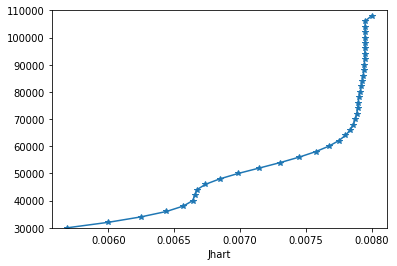

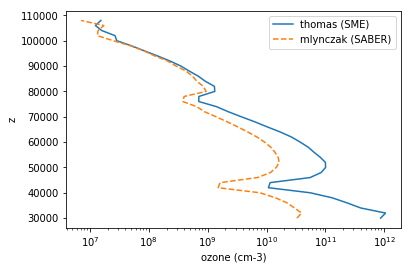

In [46]:
from chemi import ozone_mlynczak
im = 6
O2sd_ver = result_1d_pre[im]
#O2sd_ver = result_1d_pre[im]
O2sd_ver = np.abs(O2sd_ver)

def oxygen_atom(m, T, o3, j3):
    #only works for day, not night
    #(smith et al. 2011)
    o2 = 0.21*m
    ka = 6e-34*(300/T)**2.4
    kb = 8e-12 * np.exp(-2060 / T)
    o = j3 * o3 / (ka * o2 * m - kb * o3)
    return abs(o)

O3 = np.zeros(z.shape)
O = np.zeros(z.shape)
Jhart = np.zeros(z.shape)
Jlya = np.zeros(z.shape)
Jsrc = np.zeros(z.shape)
jhart_max = 8e-3
jlya_max = 4.5e-9
jsrc_max = 6.3e-6

# top layer with max
Jhart[-1] = jhart_max
Jlya[-1] = jlya_max
Jsrc[-1] = jsrc_max
O3[-1] = ozone_mlynczak(O2sd_ver[-1], T[-1], M[-1], 0, 0, 
                        Jhart[-1], Jlya[-1], Jsrc[-1], gA[-1])

# from the second top layers ......
for i in range(len(z)-2, -1, -1):
   
    tau_o2 = sO2 * O2.dot(pathl[i+1,:])
    tau_n2 = sN2 * N2.dot(pathl[i+1,:])
    tau_o3 = sO3 * O3.dot(pathl[i+1,:])
    tau_o = sO * O.dot(pathl[i+1,:])
    tau = tau_o2 + tau_n2 + tau_o3 + tau_o
    #tau = tau_o3    

    jO3 = irrad * sO3 * np.exp(-tau)
    jO2 = irrad * sO2 * np.exp(-tau)
    jhart = jO3[hartrange].sum()
    jlya = jO2[lyarange].sum()
    jsrc = jO2[srcrange].sum()
    j3 = jO3.sum()
        
    Jhart[i] = jhart
    Jlya[i] = jlya
    Jsrc[i] = jsrc
    O3[i] = ozone_mlynczak(O2sd_ver[i], T[i], M[i], O[i], O3[i], 
                           Jhart[i], Jlya[i], Jsrc[i], gA[i])
    
    O[i] = oxygen_atom(M[i], T[i], O3[i], j3)
    if jhart < 1e-5:
        break
        
O3_mlynczak = O3

plt.figure()
plt.plot(Jhart, z, marker='*')
plt.xlabel('Jhart')
ax = plt.gca()
ax.set(ylim=[30e3, 110e3])

plt.figure()
plt.plot(O3_thomas, z, '-', label='thomas (SME)')
plt.plot(O3_mlynczak, z, '--', label='mlynczak (SABER)')
plt.xlabel('ozone (cm-3)')
plt.ylabel('z')
ax = plt.gca()
ax.set_xscale('log')
plt.legend()
plt.show()

In [15]:
np.savez('ozone_profiles_mlynczak', O3_mlynczak, z)